In [496]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions
from matplotlib.animation import FuncAnimation


In [60]:
N = 200

square = np.zeros((N, N))
triangle = np.zeros((N, N))

In [94]:
def make_circle(N, depth, radius=50):
    t = np.linspace(0, 1, 1000)
    circle = np.zeros((N, N))
    for i in range(depth):
        curr_radius = radius + i
        x = np.round(curr_radius*np.sin(t*2*np.pi), 0).astype(int) + 100
        y = np.round(curr_radius*np.cos(t*2*np.pi), 0).astype(int) + 100
        circle[x, y] = 1
        circle[x, y] = 1
    return circle

In [139]:
def make_square(N, depth=5):
    square = np.zeros((N, N))
    quarter = N//4
    for i in range(depth):
        square[quarter+i, quarter:quarter+(N//2)] = 1
        square[quarter:quarter+(N//2), quarter+i] = 1
        square[3*quarter-i, quarter:quarter+(N//2)] = 1
        square[quarter:quarter+(N//2), 3*quarter-i] = 1
    return square

In [211]:
def make_triangle(N, depth=5):
    triangle = np.zeros((N, N))
    quarter = N//4
    x = np.arange(0, N//4, 0.5)
    y = np.round(np.sqrt(3)* x, 0).astype(int)
    for i in range(depth):
        triangle[quarter+i, quarter+i:3*quarter] = 1
        triangle[y+quarter+i, x.astype(int)+quarter+2*i] = 1
        triangle[y[::-1]+quarter+i, x.astype(int)+2*quarter+i] = 1
        
    return triangle[::-1]

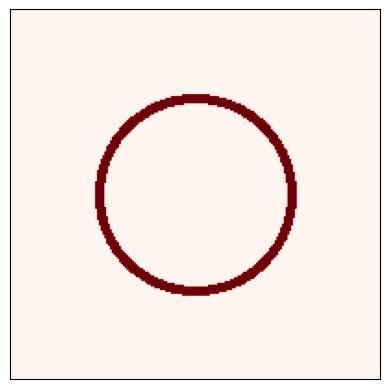

In [222]:
circle = make_circle(200, 5, radius=50)
plt.imshow(circle, cmap='Reds')
plt.gca().set_xticks([])
plt.gca().set_yticks([]);

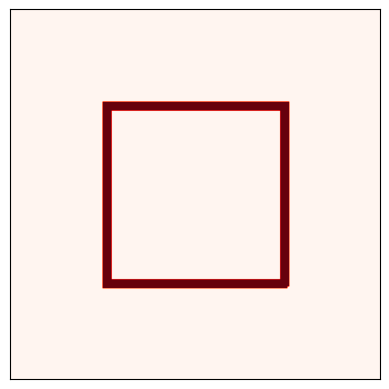

In [221]:
square = make_square(200, depth=5)
plt.imshow(square, cmap='Reds' )
plt.gca().set_xticks([])
plt.gca().set_yticks([]);

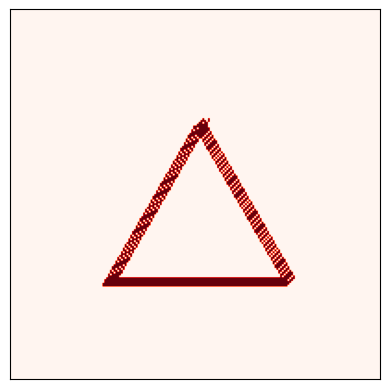

In [220]:
triangle = make_triangle(200, 5)
plt.imshow(triangle, cmap='Reds')
plt.gca().set_xticks([])
plt.gca().set_yticks([]);

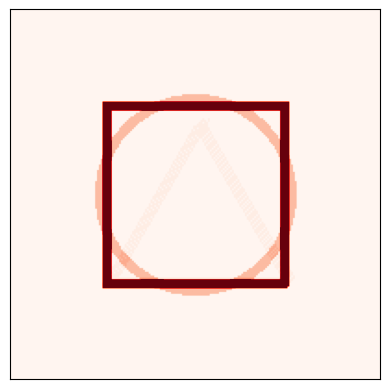

In [504]:
plt.imshow(2*square + 0.1*triangle + 0.5*circle, cmap='Reds', vmin=0, vmax=2)
plt.gca().set_xticks([])
plt.gca().set_yticks([]);

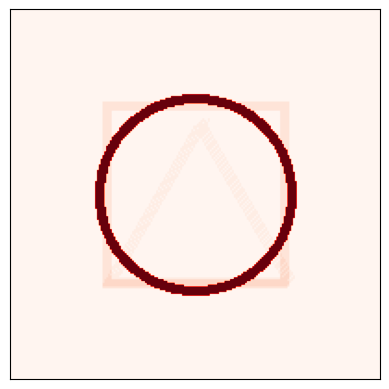

In [507]:
plt.imshow(0.2*square + 0.1*triangle + 2*circle, cmap='Reds', vmin=0, vmax=2)
plt.gca().set_xticks([])
plt.gca().set_yticks([]);

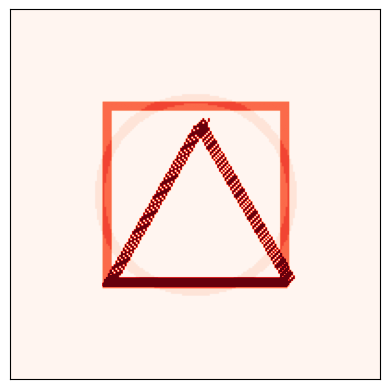

In [508]:
plt.imshow(1*square + 2*triangle + 0.2*circle, cmap='Reds', vmin=0, vmax=2)
plt.gca().set_xticks([])
plt.gca().set_yticks([]);

In [461]:
N_samples = 500

loadings = np.random.randn(N_samples, 3)
loadings = torch.nn.functional.softmax(torch.tensor(loadings), dim=1).numpy()

In [462]:
factors = np.stack([circle, square, triangle])

In [463]:
dataset = np.matmul(loadings, factors.reshape(3, -1)).reshape(len(loadings), 200, 200)

In [377]:
def plot_factors(factors, moran_idx=None, ax=None, size=2, alpha=0.8, s=0.1, names=None):
    
    max_val = np.percentile(factors, 95)
    min_val = np.percentile(factors, 5)
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(L//5, 5, figsize=(size*5, size*(L//5)), tight_layout=True)
        
    for i in range(L):
        plt.subplot(L//5, 5, i+1)
        
        curr_ax = ax[i//5, i%5]
        
        curr_ax.imshow(factors[i], cmap='Reds', vmin= min_val, vmax=max_val)

        
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [482]:
loadings

array([[0.44438075, 0.17915045, 0.3764688 ],
       [0.19101514, 0.63552368, 0.17346117],
       [0.15957763, 0.45252732, 0.38789505],
       ...,
       [0.18127163, 0.72444466, 0.09428371],
       [0.17212115, 0.43174113, 0.39613772],
       [0.20007211, 0.11517406, 0.68475383]])

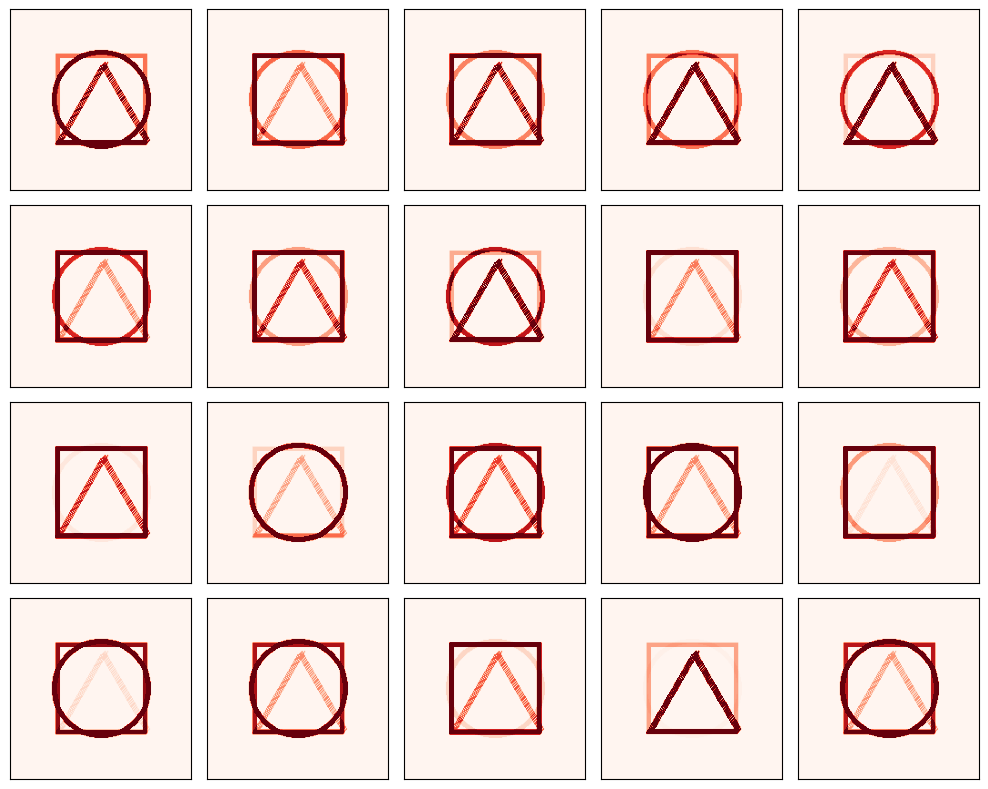

In [481]:
plot_factors(dataset[:20], size=2)

In [464]:
reshaped_dataset = dataset.reshape(N_samples, -1)

In [465]:
from gpzoo.gp import GaussianPrior
from gpzoo.likelihoods import PNMF

In [466]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [467]:
Y = torch.tensor(reshaped_dataset)

In [468]:
L = 3
prior = GaussianPrior(Y, L=L)
model = PNMF(prior, Y, L=L)
model.to(device)

PNMF(
  (prior): GaussianPrior()
)

In [469]:
def train(model, optimizer, y, device, steps=200, E=20, **kwargs):
    losses = []
    
    means = []
    scales = []
    
    for it in tqdm(range(steps)):
        
        optimizer.zero_grad()
        pY, qF, pF = model.forward(E=E, **kwargs)

        logpY = y*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qF, pF))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        #keep W and W2 positive after updates
        
        #model.W.data = torch.clamp(model.W.data, min=0.0)

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales

In [470]:
Y_train = Y.to(device)

In [471]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-1)

In [472]:
model.to(device)
losses, means, scales = train(model, optimizer, Y_train, device, steps=1000, E=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

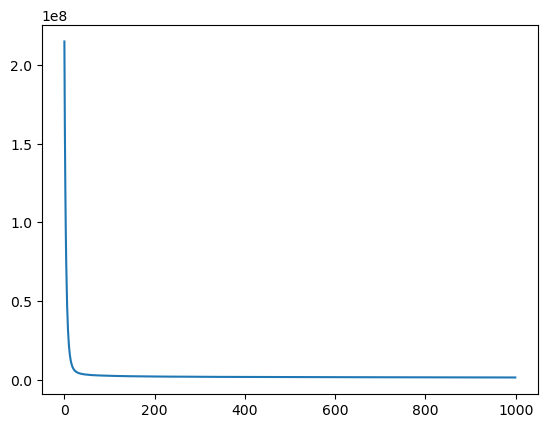

In [495]:
plt.plot(losses)

In [474]:
factors = torch.exp(model.prior.mean).detach().cpu().numpy()


In [486]:
def plot_factors2(factors, ax=None):
    
    factors_reshaped = factors.reshape(3, 200, 200)
    max_val = np.percentile(factors_reshaped, 97)
    min_val = np.percentile(factors_reshaped, 3)
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(2*3, 2), tight_layout=True)

    for i in range(3):
        curr_ax = ax[i]
        
        curr_ax.imshow(factors_reshaped[i], vmin=min_val, vmax=max_val, cmap='gray')
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])


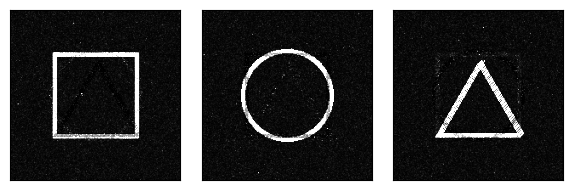

In [487]:
plot_factors2(factors)

In [493]:
size=2
fig, ax = plt.subplots(1, 3, figsize=(size*3, size), tight_layout=True)

def update(iteration):
    for element in ax:
        element.cla()
        
    curr_factor = means[iteration]
    
    
    plot_factors2(curr_factor, ax=ax)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 100, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("toy_means.mp4", fps=10, dpi=100)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99


In [44]:
import torch
indexes = torch.rand((400, 5))
Kxz = torch.rand((1200, 300))
L = 3
expanded =  indexes.repeat(L, 1)


In [46]:
expanded.shape

torch.Size([1200, 5])